In [3]:
from absl import logging
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

In [22]:
import cv2

# Load the images using OpenCV
image1 = cv2.imread('.\\images_metadata\\Gethsemane\\2019711932.jpg')
image2 = cv2.imread('.\\images_metadata\\Gethsemane\\2019711937.jpg')


In [4]:
IMAGE_1_URL='https://tile.loc.gov/storage-services/service/pnp/matpc/21100/21171v.jpg#h=747&w=1024'
IMAGE_2_URL='https://tile.loc.gov/storage-services/service/pnp/matpc/21100/21166v.jpg#h=1024&w=730'

In [10]:
image1 = '.\\images_metadata\\Gethsemane\\2019712400.jpg'
image2 = '.\\images_metadata\\Gethsemane\\2019711937.jpg'

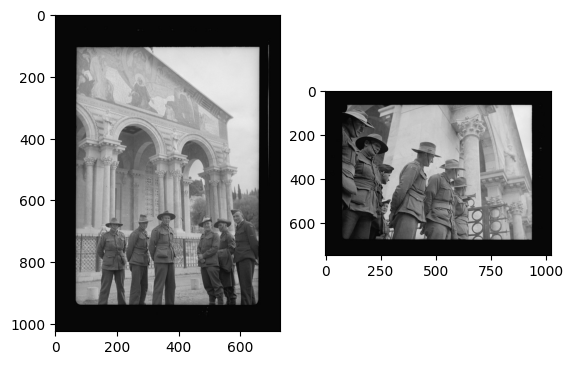

In [23]:
plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)

In [24]:
#Importing the model using tensorflow hub
delf=hub.load('https://tfhub.dev/google/delf/1').signatures['default']

In [25]:
def run_delf(image):
    np_image = np.array(image)
    float_image = tf.image.convert_image_dtype(np_image, tf.float32)
    return delf(image=float_image,score_threshold =tf.constant(100.0),image_scales=tf.constant([0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0]),max_feature_num=tf.constant(1000))
result1 = run_delf(image1)
result2 = run_delf(image2)

Loaded image 1’s 1000 features
Loaded image 2’s 899 features
Found 14 inliers


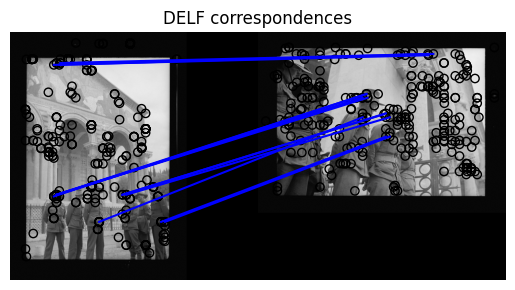

In [27]:
#Matching of both the outputs is done and inliers are calculated
#use the locations and description vectors to match the images

def match_images(image1, image2, result1, result2):
    distance_threshold = 0.8
    # Read features.
    num_features_1 = result1['locations'].shape[0]
    print("Loaded image 1’s %d features" % num_features_1)
    num_features_2 = result2['locations'].shape[0]
    print("Loaded image 2’s %d features" % num_features_2)
    # Find nearest-neighbor matches using a KD tree.
    d1_tree = cKDTree(result1['descriptors'])
    _, indices = d1_tree.query(result2['descriptors'],
      distance_upper_bound=distance_threshold)
    # Select feature locations for putative matches.
    locations_2_to_use = np.array([
      result2['locations'][i,]
    for i in range(num_features_2)
    if indices[i] != num_features_1
    ])
    locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
    ])
# Perform geometric verification using RANSAC.
    _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)
    print('Found %d inliers' % sum(inliers))
    # Visualize correspondences.
    _, ax = plt.subplots()
    inlier_idxs = np.nonzero(inliers)[0]
    plot_matches(
      ax,
      image1,
      image2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
    ax.axis('off')
    ax.set_title('DELF correspondences')
match_images(image1, image2, result1, result2)

In [29]:
image3 = cv2.imread('C:\\Users\\97455\\Downloads\\images_metadata\\Gethsemane\\2019702401.jpg')
result3 = run_delf(image3)

Loaded image 1’s 1000 features
Loaded image 2’s 1000 features
Found 11 inliers


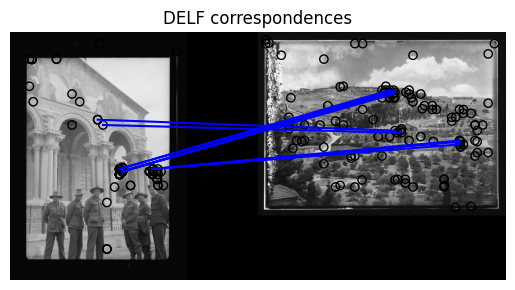

In [30]:
match_images(image1, image3, result1, result3)